# LOADING DATA

In [3]:
import os, gc
import pandas as pd

SEPT_BASE = "/kaggle/input/all-month-data"
AUG_BASE = "/kaggle/input/all-august-data"
SEPT_AIT = "/kaggle/input/ait-data/AIT SEPTEMBER.xls"
AUG_AIT = "/kaggle/input/ait-data-2/AIT AUGUST.xls"

def get_full_stats(month_name, base_path, ait_path):
    print(f"\n{'='*20} TOTAL STATS: {month_name.upper()} {'='*20}")
    
    # Load AIT IDs
    ait_data = pd.read_excel(ait_path, usecols=['msgid'])
    ait_msgids = set(ait_data['msgid'].astype(str))
    
    month_num = "08" if month_name == "august" else "09"
    total_rows = 0
    ait_found_in_logs = 0
    
    for day in range(1, 32):
        day_str = f"{day:02d}"
        f_path = f"{base_path}/{month_name}_full_message_logs_{day_str}{month_num}2025.csv"
        
        if os.path.exists(f_path):
            try:
                # ADDED encoding='latin1' to fix the UnicodeDecodeError
                chunk = pd.read_csv(f_path, usecols=[0], header=None, names=['msgid'], 
                                   engine='c', low_memory=False, encoding='latin1', 
                                   on_bad_lines='skip')
                chunk['msgid'] = chunk['msgid'].astype(str)
                
                total_rows += len(chunk)
                ait_found_in_logs += chunk['msgid'].isin(ait_msgids).sum()
                
                del chunk
                gc.collect()
            except Exception as e:
                print(f"Skipping {day_str}: {e}")
    
    print(f"📈 Total Logs Scanned: {total_rows:,}")
    print(f"🎯 AIT Found in Logs:  {ait_found_in_logs:,}")
    print(f"🏠 Normal (Ham) Logs:  {total_rows - ait_found_in_logs:,}")
    print(f"📉 Fraud Percentage:   {(ait_found_in_logs/total_rows)*100:.4f}%")
    
    return total_rows, ait_found_in_logs

sept_total, sept_ait = get_full_stats("september", SEPT_BASE, SEPT_AIT)
aug_total, aug_ait = get_full_stats("august", AUG_BASE, AUG_AIT)


==================== TOTAL STATS: SEPTEMBER ====================
📈 Total Logs Scanned: 38,767,653
🎯 AIT Found in Logs:  13,456
🏠 Normal (Ham) Logs:  38,754,197
📉 Fraud Percentage:   0.0347%

==================== TOTAL STATS: AUGUST ====================
📈 Total Logs Scanned: 35,589,690
🎯 AIT Found in Logs:  13,743
🏠 Normal (Ham) Logs:  35,575,947
📉 Fraud Percentage:   0.0386%


# EDA

In [8]:
import os, gc
import pandas as pd

# Define Paths
SEPT_BASE = "/kaggle/input/all-month-data"
AUG_BASE = "/kaggle/input/all-august-data"
SEPT_AIT = "/kaggle/input/ait-data/AIT SEPTEMBER.xls"
AUG_AIT = "/kaggle/input/ait-data-2/AIT AUGUST.xls"

# 21 original columns
cols = [
    'msgid','starttime','npdus','charcode','status','bufferedstatus',
    'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
    'note','smscid','inconnector','outconnector','mcc','mnc',
    'dlr_mcc','dlr_mnc','sms_content'
]

def perform_comprehensive_eda(name, path, is_csv=True):
    print(f"\n{'='*50}")
    print(f"📊 EDA SUMMARY: {name}")
    print(f"{'='*50}")
    
    df = None
    try:
        if is_csv:
            # Match file pattern for Day 01
            suffix = "092025.csv" if "SEPT" in name else "082025.csv"
            folder = "september" if "SEPT" in name else "august"
            sample_file = f"{path}/{folder}_full_message_logs_01{suffix}"
            
            if os.path.exists(sample_file):
                # usecols=range(21) ensures we only grab your specific columns
                df = pd.read_csv(sample_file, encoding='latin1', header=None, 
                                 names=cols, usecols=range(21), nrows=5000, 
                                 low_memory=False, on_bad_lines='skip', engine='c')
            else:
                print(f"❌ File not found: {sample_file}")
                return
        else:
            # Handle Excel AIT lists
            df = pd.read_excel(path).head(1000)

        if df is not None:
            print("\n📝 1. DATA HEAD (First 5 Rows):")
            display(df.head())

            print("\n🧬 2. COLUMN DATA TYPES (dtypes):")
            print(df.dtypes)

            print("\n🔍 3. NULL VALUE ANALYSIS (isnull.sum):")
            print(df.isnull().sum())
            
            print(f"\n📐 4. SAMPLE DIMENSIONS: {df.shape}")

    except Exception as e:
        print(f"❌ Error during EDA on {name}: {e}")
    
    finally:
        if df is not None:
            del df
        gc.collect()

# Execute EDA on all 4 components
perform_comprehensive_eda("SEPTEMBER RAW LOGS", SEPT_BASE, is_csv=True)
perform_comprehensive_eda("AUGUST RAW LOGS", AUG_BASE, is_csv=True)
perform_comprehensive_eda("SEPTEMBER AIT LIST (EXCEL)", SEPT_AIT, is_csv=False)
perform_comprehensive_eda("AUGUST AIT LIST (EXCEL)", AUG_AIT, is_csv=False)


📊 EDA SUMMARY: SEPTEMBER RAW LOGS

📝 1. DATA HEAD (First 5 Rows):


,msgid,starttime,npdus,charcode,status,bufferedstatus,msgtype,charge,sourceaddr,destaddr,...,reasontext,note,smscid,inconnector,outconnector,mcc,mnc,dlr_mcc,dlr_mnc,sms_content
0,2741222745,2025-09-01 00:00:00,1,3,1,\N,1,0.185,1xbet.com,237657782861,...,\N,\N,50ABDE9AC686F0619D2C000000005F89,smpp-in1,orange-grp-trans,\N,\N,\N,\N,<#> Code de verification 35124\\n9+bTjTtDfI5
1,2741222750,2025-09-01 00:00:05,1,1,1,\N,1,0.015,AfriDoctor,221772502846,...,\N,\N,701756683705228686,smpp-in1,tigosn-lcl,\N,\N,\N,\N,Vous avez RDV le mar. 02 sept. 2025 avec le Dr...
2,2741222751,2025-09-01 00:00:05,1,1,1,\N,1,0.015,AfriDoctor,221772616083,...,\N,\N,711756683834284053,smpp-in1,tigosn-lcl,\N,\N,\N,\N,Vous avez RDV le mar. 02 sept. 2025 avec le Dr...
3,2741222752,2025-09-01 00:00:05,1,1,1,\N,1,0.015,AfriDoctor,221773541379,...,\N,\N,701756683705277719,smpp-in1,tigosn-lcl,\N,\N,\N,\N,Vous avez RDV le mar. 02 sept. 2025 avec le Dr...
4,2741222753,2025-09-01 00:00:05,1,1,3,27,1,0.015,AfriDoctor,221771136363,...,\N,\N,711756683834334063,smpp-in1,tigosn-lcl,\N,\N,\N,\N,Vous avez RDV le mar. 02 sept. 2025 avec le Dr...



🧬 2. COLUMN DATA TYPES (dtypes):
msgid               int64
starttime          object
npdus              object
charcode            int64
status              int64
bufferedstatus     object
msgtype             int64
charge            float64
sourceaddr         object
destaddr           object
reason             object
reasontext         object
note               object
smscid             object
inconnector        object
outconnector       object
mcc                object
mnc                object
dlr_mcc            object
dlr_mnc            object
sms_content        object
dtype: object

🔍 3. NULL VALUE ANALYSIS (isnull.sum):
msgid             0
starttime         0
npdus             0
charcode          0
status            0
bufferedstatus    0
msgtype           0
charge            0
sourceaddr        0
destaddr          0
reason            0
reasontext        0
note              0
smscid            0
inconnector       0
outconnector      0
mcc               0
mnc               0
dlr_mc

,msgid,starttime,npdus,charcode,status,bufferedstatus,msgtype,charge,sourceaddr,destaddr,...,reasontext,note,smscid,inconnector,outconnector,mcc,mnc,dlr_mcc,dlr_mnc,sms_content
0,2670710128,2025-08-01 00:00:01,1,1.0,1.0,\N,1.0,0.0500,1xbet,2.207189e+09,...,\N,\N,0667ce-12116-7fe0d-05744-6ed26-24319,smpp-in1,bts-slv-wh,\N,\N,\N,\N,Your code is 8rxcruy2. Do not share it with an...
1,2670710131,2025-08-01 00:00:03,1,1.0,1.0,\N,1.0,0.0095,HaloCash,2.290163e+12,...,\N,\N,0896502811,smpp-in1,mtn-benin,\N,\N,\N,\N,<HaloCash> OTP- 522035.Ne pas divulguer.
2,2670710132,2025-08-01 00:00:04,1,3.0,1.0,\N,1.0,0.0630,PAYPAL,2.011253e+11,...,\N,\N,68820ef8-afe6-1538-f8e4-3b878ed615eb,smpp-in2,scarpel-ws,\N,\N,\N,\N,PayPal: 309778 is your security code. Don't sh...
3,2670710133,2025-08-01 00:00:04,1,1.0,1.0,\N,1.0,0.0065,BareFoot,2.557573e+11,...,\N,\N,151868313,smpp-in1,blesmpp2,\N,\N,\N,\N,Reminder: You have To-Do titled The Holy Spiri...
4,2670710134,2025-08-01 00:00:05,1,1.0,1.0,\N,1.0,0.0065,PAYLEO,2.557595e+11,...,\N,\N,151868321,smpp-in1,blesmpp2,\N,\N,\N,\N,Your ADVENT CONSTRUCTION account balance has b...



🧬 2. COLUMN DATA TYPES (dtypes):
msgid              object
starttime          object
npdus              object
charcode          float64
status            float64
bufferedstatus     object
msgtype           float64
charge            float64
sourceaddr         object
destaddr          float64
reason             object
reasontext         object
note               object
smscid             object
inconnector        object
outconnector       object
mcc                object
mnc                object
dlr_mcc            object
dlr_mnc            object
sms_content        object
dtype: object

🔍 3. NULL VALUE ANALYSIS (isnull.sum):
msgid             0
starttime         3
npdus             3
charcode          3
status            3
bufferedstatus    3
msgtype           3
charge            3
sourceaddr        3
destaddr          3
reason            3
reasontext        3
note              3
smscid            3
inconnector       3
outconnector      3
mcc               3
mnc               3
dlr_mc

,msgid,Timestamo,MSISDN,Sender ID,# of SMS,Content
0,2755140283,2025-09-06 01:17:00,25776928776,AzamTV MAX,1,AzamTV MAX - Your One time Password is 251496....
1,2755141795,2025-09-06 01:28:00,25762881350,AzamTV MAX,1,AzamTV MAX - Your One time Password is 001306....
2,2755141911,2025-09-06 01:29:00,25761420686,AzamTV MAX,1,AzamTV MAX - Your One time Password is 910192....
3,2755141986,2025-09-06 01:29:00,25768462076,AzamTV MAX,1,AzamTV MAX - Your One time Password is 839490....
4,2755142109,2025-09-06 01:30:00,25766101281,AzamTV MAX,1,AzamTV MAX - Your One time Password is 890285....



🧬 2. COLUMN DATA TYPES (dtypes):
msgid                 int64
Timestamo    datetime64[ns]
MSISDN                int64
Sender ID            object
# of SMS              int64
Content              object
dtype: object

🔍 3. NULL VALUE ANALYSIS (isnull.sum):
msgid        0
Timestamo    0
MSISDN       0
Sender ID    0
# of SMS     0
Content      0
dtype: int64

📐 4. SAMPLE DIMENSIONS: (1000, 6)

📊 EDA SUMMARY: AUGUST AIT LIST (EXCEL)

📝 1. DATA HEAD (First 5 Rows):


,msgid,Timestamp,MSISDN,Sender ID,No. of SMS,Content
0,2704170000,2025-08-16 13:49:06,263785348924,AzamTV MAX,1,AzamTV MAX - Your One time Password is 111408....
1,2704191268,2025-08-16 13:52:11,263785348924,AzamTV MAX,1,AzamTV MAX - Your One time Password is 944683....
2,2704397078,2025-08-16 15:07:47,263785348924,AzamTV MAX,1,AzamTV MAX - Your One time Password is 677512....
3,2704407653,2025-08-16 15:13:07,263785348924,AzamTV MAX,1,AzamTV MAX - Your One time Password is 007167....
4,2704487978,2025-08-16 15:31:27,263785335059,AzamTV MAX,1,AzamTV MAX - Your One time Password is 012591....



🧬 2. COLUMN DATA TYPES (dtypes):
msgid                  int64
Timestamp     datetime64[ns]
MSISDN                 int64
Sender ID             object
No. of SMS             int64
Content               object
dtype: object

🔍 3. NULL VALUE ANALYSIS (isnull.sum):
msgid         0
Timestamp     0
MSISDN        0
Sender ID     0
No. of SMS    0
Content       0
dtype: int64

📐 4. SAMPLE DIMENSIONS: (1000, 6)



🎨 Generating Visuals for: SEPTEMBER RAW LOGS


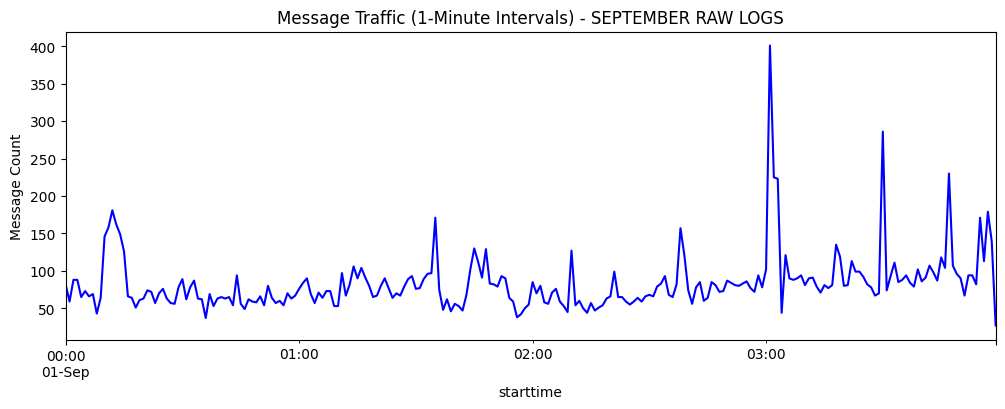

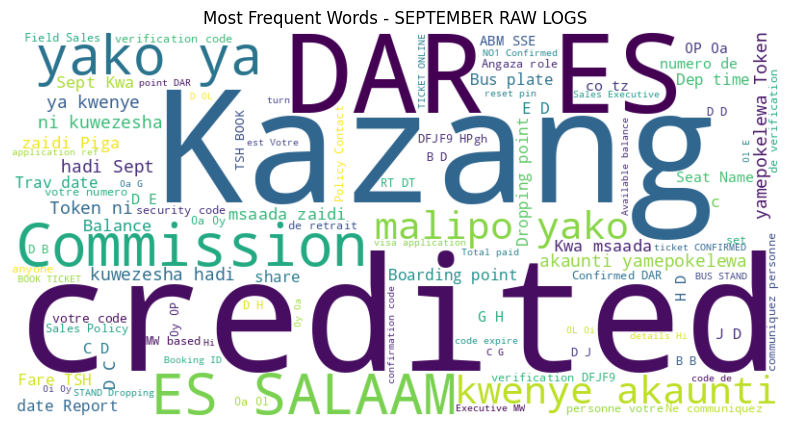


🎨 Generating Visuals for: AUGUST RAW LOGS


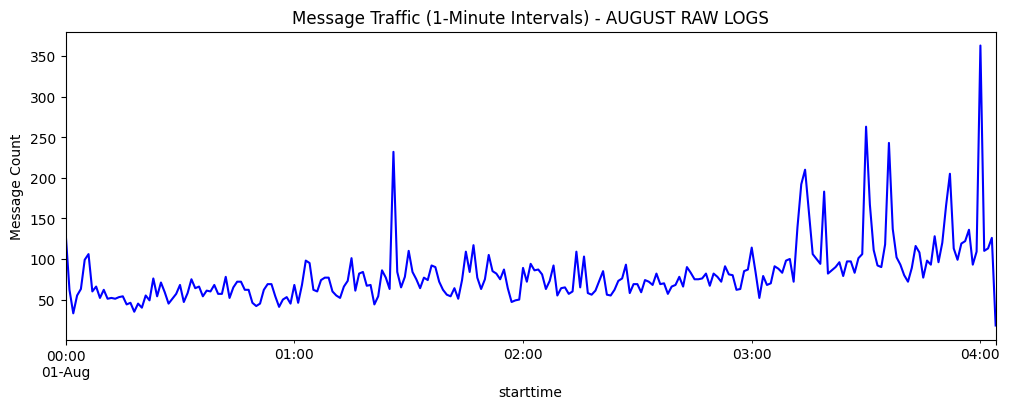

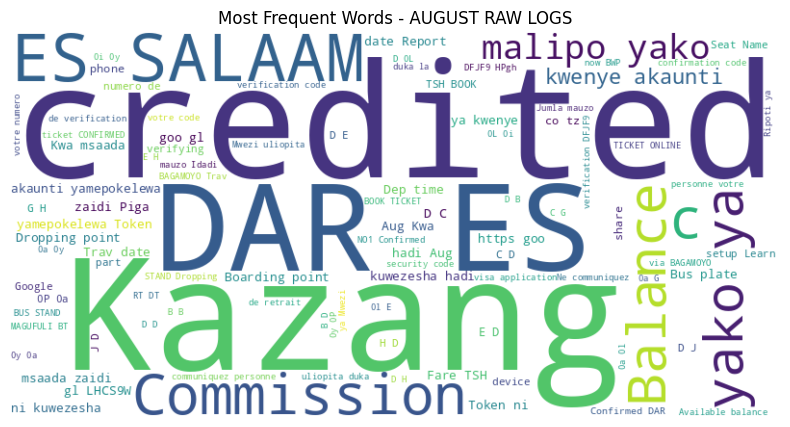


🎨 Generating Visuals for: SEPTEMBER AIT LIST


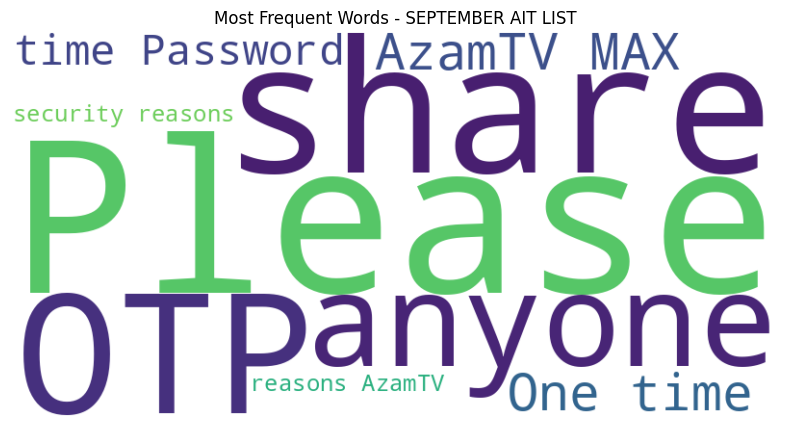


🎨 Generating Visuals for: AUGUST AIT LIST


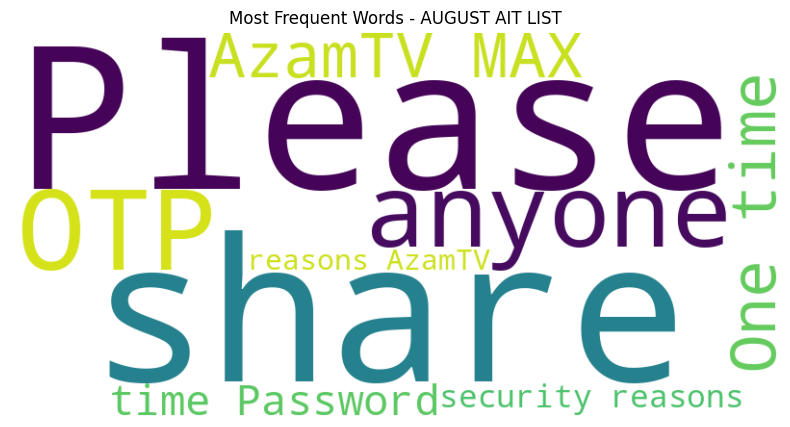

In [10]:
import os, gc
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Paths
SEPT_BASE = "/kaggle/input/all-month-data"
AUG_BASE = "/kaggle/input/all-august-data"
SEPT_AIT = "/kaggle/input/ait-data/AIT SEPTEMBER.xls"
AUG_AIT = "/kaggle/input/ait-data-2/AIT AUGUST.xls"

cols = ['msgid','starttime','npdus','charcode','status','bufferedstatus',
        'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
        'note','smscid','inconnector','outconnector','mcc','mnc',
        'dlr_mcc','dlr_mnc','sms_content']

def generate_visuals(name, path, is_csv=True):
    print(f"\n🎨 Generating Visuals for: {name}")
    df = None
    try:
        if is_csv:
            suffix = "092025.csv" if "SEPT" in name else "082025.csv"
            folder = "september" if "SEPT" in name else "august"
            # Using a larger sample (20,000 rows) for better graphs
            sample_file = f"{path}/{folder}_full_message_logs_01{suffix}"
            if os.path.exists(sample_file):
                df = pd.read_csv(sample_file, encoding='latin1', header=None, 
                                 names=cols, usecols=range(21), nrows=20000, 
                                 low_memory=False, on_bad_lines='skip')
                # 1. DRAW TRAFFIC GRAPH (Messages over time)
                df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
                traffic = df.set_index('starttime').resample('1min').count()['msgid']
                
                plt.figure(figsize=(12, 4))
                traffic.plot(title=f"Message Traffic (1-Minute Intervals) - {name}", color='blue')
                plt.ylabel("Message Count")
                plt.show()
                
            text_col = 'sms_content'
        else:
            # For Excel (AIT Lists)
            df = pd.read_excel(path).head(5000)
            # Excel might have different column names for message text
            text_col = 'sms_content' if 'sms_content' in df.columns else df.columns[-1]

        # 2. GENERATE WORDCLOUD
        if text_col in df.columns:
            text_data = " ".join(df[text_col].astype(str).tolist())
            wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                  max_words=100).generate(text_data)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f"Most Frequent Words - {name}")
            plt.axis("off")
            plt.show()

    except Exception as e:
        print(f"❌ Could not generate visuals for {name}: {e}")
    finally:
        if df is not None: del df
        gc.collect()

# Run for all 4
generate_visuals("SEPTEMBER RAW LOGS", SEPT_BASE, is_csv=True)
generate_visuals("AUGUST RAW LOGS", AUG_BASE, is_csv=True)
generate_visuals("SEPTEMBER AIT LIST", SEPT_AIT, is_csv=False)
generate_visuals("AUGUST AIT LIST", AUG_AIT, is_csv=False)

# TRAINING  ON SEPTEMBER AND TESTING ON SEPTEMBER (ALL FEATURES)

In [2]:
# ============================================================
# FULL AIT DETECTION PIPELINE (FINAL ROBUST VERSION)
# ============================================================

!pip install -q textstat lexicalrichness xgboost

import os, time, joblib
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import textstat
from lexicalrichness import LexicalRichness

# --- CONFIG ---
BASE_PATH = "/kaggle/input/all-month-data"
cols = [
    'msgid','starttime','npdus','charcode','status','bufferedstatus',
    'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
    'note','smscid','inconnector','outconnector','mcc','mnc',
    'dlr_mcc','dlr_mnc','sms_content'
]

# ============================================================
# 1. LOAD AIT LABELS
# ============================================================
print("📖 Loading AIT labels...")
ait_data = pd.read_excel('/kaggle/input/ait-data/AIT SEPTEMBER.xls')
ait_data['msgid'] = ait_data['msgid'].astype(str)
ait_msgids = set(ait_data['msgid'].tolist())

# ============================================================
# 2. LOAD & SAMPLE DATA (10% Sample)
# ============================================================
dfs = []
for day in range(1, 31):
    day_str = f"{day:02d}"
    file_path = f"{BASE_PATH}/september_full_message_logs_{day_str}092025.csv"
    if os.path.exists(file_path):
        print(f"📥 Loading: Day {day_str}")
        df_chunk = pd.read_csv(file_path, encoding="latin1", engine="c", 
                             on_bad_lines="skip", header=None, names=cols, low_memory=False)
        df_chunk['msgid'] = df_chunk['msgid'].astype(str)
        is_ait = df_chunk['msgid'].isin(ait_msgids)
        df_ait = df_chunk[is_ait].copy()
        df_normal = df_chunk[~is_ait].sample(frac=0.1, random_state=42) # 10% Sample
        dfs.append(pd.concat([df_ait, df_normal]))
        del df_chunk, df_ait, df_normal

all_data = pd.concat(dfs, ignore_index=True)
all_data['label'] = all_data['msgid'].isin(ait_msgids).astype(int)

print(f"\n✅ DATASET READY. Shape: {all_data.shape}")
print(f"📊 LABEL DISTRIBUTION:\n{all_data['label'].value_counts()}")

# ============================================================
# 3. CLEANING & FEATURES (WITH \N FIX)
# ============================================================
all_data = all_data.fillna('')
all_data['sms_content'] = all_data['sms_content'].astype(str)
all_data['starttime'] = pd.to_datetime(all_data['starttime'], errors='coerce')

# Numeric features with safety forcing
num_cols = ['npdus','status']
for col in num_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce').fillna(0)

# Behavioral Features
all_data['msg_len'] = all_data['sms_content'].str.len()
all_data['digit_ratio'] = all_data['sms_content'].apply(lambda s: sum(c.isdigit() for c in s) / max(len(s),1))
all_data['unique_chars'] = all_data['sms_content'].apply(lambda s: len(set(s)))
all_data['msg_count_global'] = all_data['sms_content'].map(all_data['sms_content'].value_counts())
all_data['hour'] = all_data['starttime'].dt.hour.fillna(0).astype(int)
all_data['is_midnight'] = all_data['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
all_data['src_count'] = all_data['sourceaddr'].map(all_data['sourceaddr'].value_counts())
all_data['dst_count'] = all_data['destaddr'].map(all_data['destaddr'].value_counts())
all_data['dest_prefix_count'] = all_data['destaddr'].astype(str).str[:6].map(all_data['destaddr'].astype(str).str[:6].value_counts())

# Per-source repetition
per_src_msg = all_data.groupby(['sourceaddr','sms_content']).size().rename('per_src_msg_count').reset_index()
all_data = all_data.merge(per_src_msg, on=['sourceaddr','sms_content'], how='left')
src_total = all_data.groupby('sourceaddr').size().rename('src_total').reset_index()
all_data = all_data.merge(src_total, on='sourceaddr', how='left')
all_data['per_src_msg_ratio'] = all_data['per_src_msg_count'] / all_data['src_total']

# Safety: Force ALL calculated numeric columns to be float (kills the \N error)
feat_cols = ['msg_len','digit_ratio','unique_chars','msg_count_global','hour','is_midnight',
             'src_count','dst_count','dest_prefix_count','per_src_msg_count','per_src_msg_ratio']
for col in feat_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce').fillna(0)

# ============================================================
# 4. STYLOMETRIC FEATURES
# ============================================================
def stylo(text):
    text = str(text).strip()
    if len(text) == 0: return pd.Series([0]*11)
    words = text.split()
    try:
        lex = LexicalRichness(text); ttr, rttr = lex.ttr, lex.rttr
    except: ttr = rttr = 0
    hapax = sum(1 for w in Counter(words).values() if w == 1) / max(len(words),1)
    avg_wl = np.mean([len(w) for w in words]) if words else 0
    try:
        fk, gf = textstat.flesch_kincaid_grade(text), textstat.gunning_fog(text)
    except: fk = gf = 0
    return pd.Series([ttr, rttr, hapax, avg_wl, fk, gf, text.count(',')/len(text),
                    text.count('!')/len(text), text.count('?')/len(text),
                    text.count('...')/len(text), sum(c.isupper() for c in text)/len(text)])

print("🧪 Extracting Stylometric features (large dataset - please wait)...")
stylo_df = all_data['sms_content'].apply(stylo)
stylo_df.columns = ['ttr','rttr','hapax_rate','avg_word_len','flesch_grade','gunning_fog',
                    'comma_ratio','exclamation_ratio','question_ratio','ellipsis_ratio','capital_ratio']

# ============================================================
# 5. MATRIX & SPLIT
# ============================================================
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,2), sublinear_tf=True, max_features=5000)
X_text = tfidf.fit_transform(all_data['sms_content'])

X_num_raw = pd.concat([all_data[num_cols + feat_cols], stylo_df], axis=1)
X_num = csr_matrix(StandardScaler().fit_transform(X_num_raw))
X = hstack([X_text, X_num], format='csr')
y = all_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\n📈 SPLIT INFO: Train AIT: {sum(y_train)}, Test AIT: {sum(y_test)}")

# ============================================================
# 6. MODELS & EVALUATION (INCLUDING INFERENCE TIME)
# ============================================================
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "LinearSVM": LinearSVC(class_weight="balanced", max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=(sum(y==0)/sum(y==1)))
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    t0 = time.time()
    model.fit(X_train, y_train)
    t_train = time.time() - t0
    
    t1 = time.time()
    y_pred = model.predict(X_test)
    t_inf = time.time() - t1
    
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    results.append([name, round(acc, 4), round(f1, 4), round(t_train, 2), round(t_inf, 4)])
    print(f"   CM:\n{confusion_matrix(y_test, y_pred)}")

summary_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score', 'Train(s)', 'Inf(s)'])
print("\n--- FINAL PERFORMANCE COMPARISON ---")
print(summary_df.sort_values(by='F1-Score', ascending=False))

📖 Loading AIT labels...
📥 Loading: Day 01
📥 Loading: Day 02
📥 Loading: Day 03
📥 Loading: Day 04
📥 Loading: Day 05
📥 Loading: Day 06
📥 Loading: Day 07
📥 Loading: Day 08
📥 Loading: Day 09
📥 Loading: Day 10
📥 Loading: Day 11
📥 Loading: Day 12
📥 Loading: Day 13
📥 Loading: Day 14
📥 Loading: Day 15
📥 Loading: Day 16
📥 Loading: Day 17
📥 Loading: Day 18
📥 Loading: Day 19
📥 Loading: Day 20
📥 Loading: Day 21
📥 Loading: Day 22
📥 Loading: Day 23
📥 Loading: Day 24
📥 Loading: Day 25
📥 Loading: Day 26
📥 Loading: Day 27
📥 Loading: Day 28
📥 Loading: Day 29
📥 Loading: Day 30

✅ DATASET READY. Shape: (3886412, 22)
📊 LABEL DISTRIBUTION:
label
0    3872956
1      13456
Name: count, dtype: int64
🧪 Extracting Stylometric features (large dataset - please wait)...

📈 SPLIT INFO: Train AIT: 10765, Test AIT: 2691

🚀 Training LogReg...
   CM:
[[773103   1489]
 [     0   2691]]

🚀 Training LinearSVM...
   CM:
[[773129   1463]
 [     0   2691]]

🚀 Training DecisionTree...
   CM:
[[774572     20]
 [     3   2688]]



# TRAINING ON SEPTEMBER AND TESTING ON AUGUST

## ALL FEATURES (META DATA AND LIGUISTIC)

In [1]:
# ============================================================
# CROSS-MONTH AIT DETECTION (SEPTEMBER -> AUGUST)
# ============================================================

!pip install -q textstat lexicalrichness xgboost

import os, time, joblib
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import textstat
from lexicalrichness import LexicalRichness

# --- GLOBAL CONFIG ---
cols = [
    'msgid','starttime','npdus','charcode','status','bufferedstatus',
    'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
    'note','smscid','inconnector','outconnector','mcc','mnc',
    'dlr_mcc','dlr_mnc','sms_content'
]

def stylo(text):
    text = str(text).strip()
    if len(text) == 0: return pd.Series([0]*11)
    words = text.split()
    try:
        lex = LexicalRichness(text); ttr, rttr = lex.ttr, lex.rttr
    except: ttr = rttr = 0
    hapax = sum(1 for w in Counter(words).values() if w == 1) / max(len(words),1)
    avg_wl = np.mean([len(w) for w in words]) if words else 0
    try:
        fk, gf = textstat.flesch_kincaid_grade(text), textstat.gunning_fog(text)
    except: fk = gf = 0
    return pd.Series([ttr, rttr, hapax, avg_wl, fk, gf, text.count(',')/len(text),
                    text.count('!')/len(text), text.count('?')/len(text),
                    text.count('...')/len(text), sum(c.isupper() for c in text)/len(text)])

# ============================================================
# 1. DATA LOADING FUNCTION (SAVES REPETITION)
# ============================================================
def get_month_data(month_name, base_path, ait_path):
    print(f"\n📂 Loading {month_name.upper()}...")
    ait_data = pd.read_excel(ait_path)
    ait_data['msgid'] = ait_data['msgid'].astype(str)
    ait_msgids = set(ait_data['msgid'].tolist())
    
    month_num = "08" if month_name == "august" else "09"
    dfs = []
    for day in range(1, 31):
        day_str = f"{day:02d}"
        f_path = f"{base_path}/{month_name}_full_message_logs_{day_str}{month_num}2025.csv"
        if os.path.exists(f_path):
            df_c = pd.read_csv(f_path, encoding="latin1", engine="c", on_bad_lines="skip", header=None, names=cols, low_memory=False)
            df_c['msgid'] = df_c['msgid'].astype(str)
            is_ait = df_c['msgid'].isin(ait_msgids)
            dfs.append(pd.concat([df_c[is_ait], df_c[~is_ait].sample(frac=0.1, random_state=42)]))
            
    df = pd.concat(dfs, ignore_index=True)
    df['label'] = df['msgid'].isin(ait_msgids).astype(int)
    df = df.fillna('')
    df['sms_content'] = df['sms_content'].astype(str)
    df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
    
    # --- FEATURES (Same as before) ---
    df['msg_len'] = df['sms_content'].str.len()
    df['digit_ratio'] = df['sms_content'].apply(lambda s: sum(c.isdigit() for c in s) / max(len(s),1))
    df['unique_chars'] = df['sms_content'].apply(lambda s: len(set(s)))
    df['msg_count_global'] = df['sms_content'].map(df['sms_content'].value_counts())
    df['hour'] = df['starttime'].dt.hour.fillna(0).astype(int)
    df['is_midnight'] = df['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
    df['src_count'] = df['sourceaddr'].map(df['sourceaddr'].value_counts())
    df['dst_count'] = df['destaddr'].map(df['destaddr'].value_counts())
    df['dest_prefix_count'] = df['destaddr'].astype(str).str[:6].map(df['destaddr'].astype(str).str[:6].value_counts())
    per_src = df.groupby(['sourceaddr','sms_content']).size().rename('per_src_msg_count').reset_index()
    df = df.merge(per_src, on=['sourceaddr','sms_content'], how='left')
    src_total = df.groupby('sourceaddr').size().rename('src_total').reset_index()
    df = df.merge(src_total, on='sourceaddr', how='left')
    df['per_src_msg_ratio'] = df['per_src_msg_count'] / df['src_total']
    
    # Numeric Cleanup (\N Fix)
    num_cols = ['npdus','status','msg_len','digit_ratio','unique_chars','msg_count_global',
                'hour','is_midnight','src_count','dst_count','dest_prefix_count',
                'per_src_msg_count','per_src_msg_ratio']
    for c in num_cols: df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    
    print(f"🧪 Extracting stylo for {month_name}...")
    stylo_df = df['sms_content'].apply(stylo)
    stylo_df.columns = ['ttr','rttr','hapax_rate','avg_word_len','flesch_grade','gunning_fog','comma_ratio','exclamation_ratio','question_ratio','ellipsis_ratio','capital_ratio']
    
    return df, stylo_df, num_cols

# ============================================================
# 2. LOAD BOTH MONTHS
# ============================================================
sept_df, sept_stylo, num_cols = get_month_data("september", "/kaggle/input/all-month-data", "/kaggle/input/ait-data/AIT SEPTEMBER.xls")
aug_df, aug_stylo, _ = get_month_data("august", "/kaggle/input/all-august-data", "/kaggle/input/ait-data-2/AIT AUGUST.xls")

# ============================================================
# 3. VECTORIZATION (CRITICAL: Fit on Sept, Transform August)
# ============================================================
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,2), sublinear_tf=True, max_features=5000)
scaler = StandardScaler()

# Training Set (Sept)
X_train_text = tfidf.fit_transform(sept_df['sms_content'])
X_train_num = csr_matrix(scaler.fit_transform(pd.concat([sept_df[num_cols], sept_stylo], axis=1)))
X_train = hstack([X_train_text, X_train_num], format='csr')
y_train = sept_df['label'].values

# Unseen Test Set (Aug)
X_unseen_text = tfidf.transform(aug_df['sms_content'])
X_unseen_num = csr_matrix(scaler.transform(pd.concat([aug_df[num_cols], aug_stylo], axis=1)))
X_unseen = hstack([X_unseen_text, X_unseen_num], format='csr')
y_unseen = aug_df['label'].values

print(f"\n📊 Label Dist - Sept (Train): {dict(Counter(y_train))}")
print(f"📊 Label Dist - Aug (Unseen): {dict(Counter(y_unseen))}")

# ============================================================
# 4. ALL MODELS
# ============================================================
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "LinearSVM": LinearSVC(class_weight="balanced", max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=(sum(y_train==0)/sum(y_train==1)))
}

results = []
for name, model in models.items():
    print(f"\n🚀 Training {name} on September...")
    model.fit(X_train, y_train)
    
    print(f"🧐 Testing {name} on Unseen August...")
    t0 = time.time()
    y_pred = model.predict(X_unseen)
    inf_time = time.time() - t0
    
    f1 = f1_score(y_unseen, y_pred)
    acc = accuracy_score(y_unseen, y_pred)
    cm = confusion_matrix(y_unseen, y_pred)
    
    results.append([name, round(acc, 4), round(f1, 4), round(inf_time, 4)])
    print(f"Confusion Matrix:\n{cm}")

# ============================================================
# 5. FINAL COMPARISON
# ============================================================
summary = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score (August)', 'Inf Time(s)'])
print("\n--- PERFORMANCE ON UNSEEN DATA (AUGUST) ---")
print(summary.sort_values(by='F1-Score (August)', ascending=False))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00:00:01

📂 Loading SEPTEMBER...
🧪 Extracting stylo for september...

📂 Loading AUGUST...
🧪 Extracting stylo for august...

📊 Label Dist - Sept (Train): {np.int64(0): 3872956, np.int64(1): 13456}
📊 Label Dist - Aug (Unseen): {np.int64(0): 3413301, np.int64(1): 13743}

🚀 Training LogReg on September...
🧐 Testing LogReg on Unseen August...
Confusion Matrix:
[[3407628    5673]
 [  13707      36]]

🚀 Training LinearSVM on September...
🧐 Testing LinearSVM on Unseen August...
Confusion Matrix:
[[3412532     769]
 [  13718      25]]

🚀 Training DecisionTree on September...
🧐 Testing DecisionTree on Unseen August...
Confusion Matrix:
[[3413274      27]
 [  13743       0]]

🚀 Training RandomForest on September...
🧐 Testing R

## SELECTING META DATA FEATURES ONLY

In [1]:
# ============================================================
# CROSS-MONTH AIT DETECTION (NUMERICAL + TFIDF ONLY)
# ============================================================

!pip install -q textstat lexicalrichness xgboost

import os, time, joblib, gc
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import textstat
# from lexicalrichness import LexicalRichness # Commented out

# --- GLOBAL CONFIG ---
cols = [
    'msgid','starttime','npdus','charcode','status','bufferedstatus',
    'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
    'note','smscid','inconnector','outconnector','mcc','mnc',
    'dlr_mcc','dlr_mnc','sms_content'
]

# --- COMMENTED STYLO FUNCTION ---
"""
def stylo(text):
    text = str(text).strip()
    if len(text) == 0: return pd.Series([0]*11)
    words = text.split()
    try:
        lex = LexicalRichness(text); ttr, rttr = lex.ttr, lex.rttr
    except: ttr = rttr = 0
    hapax = sum(1 for w in Counter(words).values() if w == 1) / max(len(words),1)
    avg_wl = np.mean([len(w) for w in words]) if words else 0
    try:
        fk, gf = textstat.flesch_kincaid_grade(text), textstat.gunning_fog(text)
    except: fk = gf = 0
    return pd.Series([ttr, rttr, hapax, avg_wl, fk, gf, text.count(',')/len(text),
                    text.count('!')/len(text), text.count('?')/len(text),
                    text.count('...')/len(text), sum(c.isupper() for c in text)/len(text)])
"""

# ============================================================
# 1. DATA LOADING FUNCTION
# ============================================================
def get_month_data(month_name, base_path, ait_path):
    print(f"\n📂 Loading {month_name.upper()}...")
    ait_data = pd.read_excel(ait_path)
    ait_data['msgid'] = ait_data['msgid'].astype(str)
    ait_msgids = set(ait_data['msgid'].tolist())
    
    month_num = "08" if month_name == "august" else "09"
    dfs = []
    for day in range(1, 31):
        day_str = f"{day:02d}"
        f_path = f"{base_path}/{month_name}_full_message_logs_{day_str}{month_num}2025.csv"
        if os.path.exists(f_path):
            df_c = pd.read_csv(f_path, encoding="latin1", engine="c", on_bad_lines="skip", 
                               header=None, names=cols, low_memory=False)
            df_c['msgid'] = df_c['msgid'].astype(str)
            is_ait = df_c['msgid'].isin(ait_msgids)
            dfs.append(pd.concat([df_c[is_ait], df_c[~is_ait].sample(frac=0.1, random_state=42)]))
            
    df = pd.concat(dfs, ignore_index=True)
    df['label'] = df['msgid'].isin(ait_msgids).astype(int)
    # --- LABEL DISTRIBUTION ---
    dist = Counter(df['label'])
    print(f"📊 {month_name.upper()} LABEL DISTRIBUTION:")
    print(f"   - Normal (Ham): {dist[0]}")
    print(f"   - Fraud (AIT):  {dist[1]}")
    print(f"   - Total Rows:   {len(df)}")
    df = df.fillna('')
    df['sms_content'] = df['sms_content'].astype(str)
    df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
    
    # --- LISTING COMPANIES BY NAME (VALUE COUNTS) ---
    print(f"\n🏢 TOP 15 COMPANIES BY VOLUME ({month_name.upper()}):")
    print(df['sourceaddr'].value_counts().head(15))
    
    # --- FEATURES ---
    df['msg_len'] = df['sms_content'].str.len()
    df['digit_ratio'] = df['sms_content'].apply(lambda s: sum(c.isdigit() for c in s) / max(len(s),1))
    df['unique_chars'] = df['sms_content'].apply(lambda s: len(set(s)))
    df['msg_count_global'] = df['sms_content'].map(df['sms_content'].value_counts())
    df['hour'] = df['starttime'].dt.hour.fillna(0).astype(int)
    df['is_midnight'] = df['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
    df['src_count'] = df['sourceaddr'].map(df['sourceaddr'].value_counts())
    df['dst_count'] = df['destaddr'].map(df['destaddr'].value_counts())
    df['dest_prefix_count'] = df['destaddr'].astype(str).str[:6].map(df['destaddr'].astype(str).str[:6].value_counts())
    
    per_src = df.groupby(['sourceaddr','sms_content']).size().rename('per_src_msg_count').reset_index()
    df = df.merge(per_src, on=['sourceaddr','sms_content'], how='left')
    src_total = df.groupby('sourceaddr').size().rename('src_total').reset_index()
    df = df.merge(src_total, on='sourceaddr', how='left')
    df['per_src_msg_ratio'] = df['per_src_msg_count'] / df['src_total']
    
    num_cols = ['npdus','status','msg_len','digit_ratio','unique_chars','msg_count_global',
                'hour','is_midnight','src_count','dst_count','dest_prefix_count',
                'per_src_msg_count','per_src_msg_ratio']
    
    for c in num_cols: df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    
    # --- STYLO COMMENTED OUT ---
    # print(f"🧪 Extracting stylo for {month_name}...")
    # stylo_df = df['sms_content'].apply(stylo)
    
    return df, num_cols

# ============================================================
# 2. LOAD BOTH MONTHS
# ============================================================
sept_df, num_cols = get_month_data("september", "/kaggle/input/all-month-data", "/kaggle/input/ait-data/AIT SEPTEMBER.xls")
aug_df, _ = get_month_data("august", "/kaggle/input/all-august-data", "/kaggle/input/ait-data-2/AIT AUGUST.xls")

# --- SENDER SOURCE ANALYSIS ---
sept_src = set(sept_df['sourceaddr'].unique())
aug_src = set(aug_df['sourceaddr'].unique())
print(f"\n🏢 SOURCE OVERLAP: {len(sept_src.intersection(aug_src))} common companies.")
print(f"🏢 NEW COMPANIES IN AUG: {len(aug_src - sept_src)}")

# ============================================================
# 3. VECTORIZATION & SCALING
# ============================================================
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,2), sublinear_tf=True, max_features=5000)
scaler = StandardScaler()

# Training Set (Sept)
X_train_text = tfidf.fit_transform(sept_df['sms_content'])
X_train_num = csr_matrix(scaler.fit_transform(sept_df[num_cols])) # Only numerical
X_train = hstack([X_train_text, X_train_num], format='csr')
y_train = sept_df['label'].values

# Unseen Test Set (Aug)
X_unseen_text = tfidf.transform(aug_df['sms_content'])
X_unseen_num = csr_matrix(scaler.transform(aug_df[num_cols]))
X_unseen = hstack([X_unseen_text, X_unseen_num], format='csr')
y_unseen = aug_df['label'].values

# Memory Clean up
del sept_df, aug_df; gc.collect()

# ============================================================
# 4. RUN ALL MODELS
# ============================================================
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "LinearSVM": LinearSVC(class_weight="balanced", max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=(sum(y_train==0)/sum(y_train==1)))
}

results = []
for name, model in models.items():
    print(f"\n🚀 Processing {name}...")
    t_start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t_start
    
    t_inf_start = time.time()
    y_pred = model.predict(X_unseen)
    inf_time = time.time() - t_inf_start
    
    f1 = f1_score(y_unseen, y_pred)
    acc = accuracy_score(y_unseen, y_pred)
    
    results.append([name, round(acc, 4), round(f1, 4), round(train_time, 2), round(inf_time, 4)])
    print(f"Confusion Matrix (August):\n{confusion_matrix(y_unseen, y_pred)}")

# ============================================================
# 5. FINAL COMPARISON
# ============================================================
summary = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score', 'Train Time(s)', 'Inf Time(s)'])
print("\n--- PERFORMANCE SUMMARY (ON UNSEEN AUGUST DATA) ---")
print(summary.sort_values(by='F1-Score', ascending=False))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.2 MB/s eta 0:00:0000:01

📂 Loading SEPTEMBER...
📊 SEPTEMBER LABEL DISTRIBUTION:
   - Normal (Ham): 3872956
   - Fraud (AIT):  13456
   - Total Rows:   3886412

🏢 TOP 15 COMPANIES BY VOLUME (SEPTEMBER):
sourceaddr
SUNKING        1171987
SunKing         447466
PMBET           230823
Sunking         154335
AzamTV MAX      120776
StanChart       103408
PAYPAL           82875
Uganda22BET      62699
VFS              59123
Naija 22BET      57367
WAVE             55002
Street           50568
Soleva Togo      43565
WhatsApp         42935
GSB              40348
Name: count, dtype: int64

📂 Loading AUGUST...
📊 AUGUST LABEL DISTRIBUTION:
   - Normal (Ham): 3413301
   - Fraud (AIT):  13743
   - Total Rows:   3427044

🏢 TOP 15 COMPANIES BY VOLUM

## SELECTING LINGUISTIC FEATURES ONLY

In [2]:
# ============================================================
# CROSS-MONTH AIT DETECTION (STYLO + TFIDF ONLY)
# NUMERICAL FEATURES COMMENTED OUT
# ============================================================

!pip install -q textstat lexicalrichness xgboost

import os, time, joblib, gc
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import textstat
from lexicalrichness import LexicalRichness # UNCOMMENTED

# --- GLOBAL CONFIG ---
cols = [
    'msgid','starttime','npdus','charcode','status','bufferedstatus',
    'msgtype','charge','sourceaddr','destaddr','reason','reasontext',
    'note','smscid','inconnector','outconnector','mcc','mnc',
    'dlr_mcc','dlr_mnc','sms_content'
]

# --- STYLO FUNCTION (RE-ACTIVATED) ---
def stylo(text):
    text = str(text).strip()
    if len(text) == 0: return pd.Series([0]*11)
    words = text.split()
    try:
        lex = LexicalRichness(text); ttr, rttr = lex.ttr, lex.rttr
    except: ttr = rttr = 0
    hapax = sum(1 for w in Counter(words).values() if w == 1) / max(len(words),1)
    avg_wl = np.mean([len(w) for w in words]) if words else 0
    try:
        fk, gf = textstat.flesch_kincaid_grade(text), textstat.gunning_fog(text)
    except: fk = gf = 0
    return pd.Series([ttr, rttr, hapax, avg_wl, fk, gf, text.count(',')/len(text),
                    text.count('!')/len(text), text.count('?')/len(text),
                    text.count('...')/len(text), sum(c.isupper() for c in text)/len(text)])

# ============================================================
# 1. DATA LOADING FUNCTION
# ============================================================
def get_month_data(month_name, base_path, ait_path):
    print(f"\n📂 Loading {month_name.upper()}...")
    ait_data = pd.read_excel(ait_path)
    ait_data['msgid'] = ait_data['msgid'].astype(str)
    ait_msgids = set(ait_data['msgid'].tolist())
    
    month_num = "08" if month_name == "august" else "09"
    dfs = []
    for day in range(1, 31):
        day_str = f"{day:02d}"
        f_path = f"{base_path}/{month_name}_full_message_logs_{day_str}{month_num}2025.csv"
        if os.path.exists(f_path):
            df_c = pd.read_csv(f_path, encoding="latin1", engine="c", on_bad_lines="skip", 
                               header=None, names=cols, low_memory=False)
            df_c['msgid'] = df_c['msgid'].astype(str)
            is_ait = df_c['msgid'].isin(ait_msgids)
            dfs.append(pd.concat([df_c[is_ait], df_c[~is_ait].sample(frac=0.1, random_state=42)]))
            
    df = pd.concat(dfs, ignore_index=True)
    df['label'] = df['msgid'].isin(ait_msgids).astype(int)
    
    # --- LABEL DISTRIBUTION ---
    dist = Counter(df['label'])
    print(f"📊 {month_name.upper()} LABEL DISTRIBUTION:")
    print(f"    - Normal (Ham): {dist[0]}")
    print(f"    - Fraud (AIT):  {dist[1]}")
    
    df = df.fillna('')
    df['sms_content'] = df['sms_content'].astype(str)
    
    # --- NUMERICAL FEATURES (COMMENTED OUT) ---
    """
    df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
    df['msg_len'] = df['sms_content'].str.len()
    df['digit_ratio'] = df['sms_content'].apply(lambda s: sum(c.isdigit() for c in s) / max(len(s),1))
    df['unique_chars'] = df['sms_content'].apply(lambda s: len(set(s)))
    df['msg_count_global'] = df['sms_content'].map(df['sms_content'].value_counts())
    df['hour'] = df['starttime'].dt.hour.fillna(0).astype(int)
    df['is_midnight'] = df['hour'].apply(lambda h: 1 if h>=22 or h<=4 else 0)
    df['src_count'] = df['sourceaddr'].map(df['sourceaddr'].value_counts())
    df['dst_count'] = df['destaddr'].map(df['destaddr'].value_counts())
    df['dest_prefix_count'] = df['destaddr'].astype(str).str[:6].map(df['destaddr'].astype(str).str[:6].value_counts())
    
    per_src = df.groupby(['sourceaddr','sms_content']).size().rename('per_src_msg_count').reset_index()
    df = df.merge(per_src, on=['sourceaddr','sms_content'], how='left')
    src_total = df.groupby('sourceaddr').size().rename('src_total').reset_index()
    df = df.merge(src_total, on='sourceaddr', how='left')
    df['per_src_msg_ratio'] = df['per_src_msg_count'] / df['src_total']
    
    num_cols = ['npdus','status','msg_len','digit_ratio','unique_chars','msg_count_global',
                'hour','is_midnight','src_count','dst_count','dest_prefix_count',
                'per_src_msg_count','per_src_msg_ratio']
    
    for c in num_cols: df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
    """
    
    # --- STYLO RE-ACTIVATED ---
    print(f"🧪 Extracting stylo for {month_name}...")
    stylo_df = df['sms_content'].apply(stylo)
    stylo_df.columns = ['ttr','rttr','hapax','awl','fk','gf','cm','ex','qu','el','cp']
    
    return df, stylo_df

# ============================================================
# 2. LOAD BOTH MONTHS
# ============================================================
sept_df, sept_stylo = get_month_data("september", "/kaggle/input/all-month-data", "/kaggle/input/ait-data/AIT SEPTEMBER.xls")
aug_df, aug_stylo = get_month_data("august", "/kaggle/input/all-august-data", "/kaggle/input/ait-data-2/AIT AUGUST.xls")

# ============================================================
# 3. VECTORIZATION & SCALING
# ============================================================
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,2), sublinear_tf=True, max_features=5000)
scaler = StandardScaler()

# Training Set (Sept)
X_train_text = tfidf.fit_transform(sept_df['sms_content'])
X_train_stylo = csr_matrix(scaler.fit_transform(sept_stylo)) # Using Stylometric features
X_train = hstack([X_train_text, X_train_stylo], format='csr')
y_train = sept_df['label'].values

# Unseen Test Set (Aug)
X_unseen_text = tfidf.transform(aug_df['sms_content'])
X_unseen_stylo = csr_matrix(scaler.transform(aug_stylo))
X_unseen = hstack([X_unseen_text, X_unseen_stylo], format='csr')
y_unseen = aug_df['label'].values

# Memory Clean up
del sept_df, aug_df; gc.collect()

# ============================================================
# 4. RUN ALL MODELS
# ============================================================
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "LinearSVM": LinearSVC(class_weight="balanced", max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(max_depth=20, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=20, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=(sum(y_train==0)/sum(y_train==1)))
}

results = []
for name, model in models.items():
    print(f"\n🚀 Processing {name}...")
    t_start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t_start
    
    t_inf_start = time.time()
    y_pred = model.predict(X_unseen)
    inf_time = time.time() - t_inf_start
    
    f1 = f1_score(y_unseen, y_pred)
    acc = accuracy_score(y_unseen, y_pred)
    
    results.append([name, round(acc, 4), round(f1, 4), round(train_time, 2), round(inf_time, 4)])
    print(f"Confusion Matrix (August):\n{confusion_matrix(y_unseen, y_pred)}")

# ============================================================
# 5. FINAL COMPARISON
# ============================================================
summary = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1-Score', 'Train Time(s)', 'Inf Time(s)'])
print("\n--- PERFORMANCE SUMMARY (ON UNSEEN AUGUST DATA) ---")
print(summary.sort_values(by='F1-Score', ascending=False))


📂 Loading SEPTEMBER...
📊 SEPTEMBER LABEL DISTRIBUTION:
    - Normal (Ham): 3872956
    - Fraud (AIT):  13456
🧪 Extracting stylo for september...

📂 Loading AUGUST...
📊 AUGUST LABEL DISTRIBUTION:
    - Normal (Ham): 3413301
    - Fraud (AIT):  13743
🧪 Extracting stylo for august...

🚀 Processing LogReg...
Confusion Matrix (August):
[[3379875   33426]
 [      0   13743]]

🚀 Processing LinearSVM...
Confusion Matrix (August):
[[3379899   33402]
 [      0   13743]]

🚀 Processing DecisionTree...
Confusion Matrix (August):
[[3379899   33402]
 [      0   13743]]

🚀 Processing RandomForest...
Confusion Matrix (August):
[[3379899   33402]
 [      0   13743]]

🚀 Processing XGBoost...
Confusion Matrix (August):
[[3379899   33402]
 [      0   13743]]

--- PERFORMANCE SUMMARY (ON UNSEEN AUGUST DATA) ---
          Model  Accuracy  F1-Score  Train Time(s)  Inf Time(s)
1     LinearSVM    0.9903    0.4514        1138.08       0.8325
3  RandomForest    0.9903    0.4514         157.36      13.5909
2  Dec